# Idea
![](./assets/whole_network_diagram.png "Whole Network Diagram")

# Preparations

## Imports

In [1]:
import numpy as np
from python_speech_features import mfcc, delta
import torch
from torch import nn
import torch.nn.functional as F
import os, random, torchaudio
from IPython.display import Audio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gc
from torch.amp import autocast
from torch.utils.data import Dataset, DataLoader
from torchaudio.datasets import IEMOCAP

## Set device (Tested only on GPU)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Network Implementation

In [3]:
def get_mfcc_features(X):
    # Extract MFCC features with 40 coefficients and 25ms frame size
    X = X.to('cpu')
    res = []
    for waveform in X:
        # print("Waveform shape: ", waveform.shape)
        mfcc_features = mfcc(waveform, 16000, numcep=40, winlen=0.025, nfilt=40)
        # Compute first and second-order derivatives of MFCC features
        mfcc_delta = delta(mfcc_features, 2)
        # Stack MFCC and delta features
        mfcc_features = np.hstack((mfcc_features, mfcc_delta))
        # mfcc_features = mfcc_features.transpose()
        mfcc_features = torch.tensor(mfcc_features, dtype=torch.float).to(device)
    
        res.append(mfcc_features)
    
    res = torch.stack(res)
    return res

class SER(nn.Module):
    def __init__(
        self,
        dropout = 0.,
        out_features = 8,
        ):
        super().__init__()
        self.blstm = nn.LSTM(80, 80, batch_first = True, bidirectional = True, dropout = dropout)
        # self.mha = nn.MultiheadAttention(80, 1)
        self.mha = nn.MultiheadAttention(160, 1)

        self.seq = nn.Sequential(
            nn.ReLU(),
            # nn.Dropout(dropout),
            nn.Flatten(start_dim=1),
            # nn.LazyLinear(256),
            # nn.ReLU(),
            # nn.Dropout(dropout),
            # nn.LazyLinear(128),
            # nn.ReLU(),
            # nn.LazyLinear(128),
            # nn.ReLU(),
            nn.LazyLinear(out_features=out_features),
        )
        self.dropout = nn.Dropout(dropout)

        
    def forward(self, x):
        # print("Shape before mfcc: ", x.shape)
        x = get_mfcc_features(x)
        # print("Shape after mfcc: ", x.shape)
        x, _ = self.blstm(x)
        # x = self.dropout(x)
        # print("Shape after blstm: ", x.shape)
        x,_ = self.mha(x, x, x)
        # x = self.dropout(x)
        # print("Shape after mha: ", x.shape)
        x = self.seq(x)
        # print("Shape after seq:", x.shape)
        return x

## ArcFace and Softmax Loss

In [4]:
class ArcFaceLoss(nn.Module):
    def __init__(self, num_classes, embedding_size, margin, scale):
        """
        ArcFace: Additive Angular Margin Loss for Deep Face Recognition
        (https://arxiv.org/pdf/1801.07698.pdf)
        Args:
            num_classes: The number of classes in your training dataset
            embedding_size: The size of the embeddings that you pass into
            margin: m in the paper, the angular margin penalty in radians
            scale: s in the paper, feature scale
        """
        super().__init__()
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        self.margin = margin
        self.scale = scale
        
        self.W = torch.nn.Parameter(torch.Tensor(num_classes, embedding_size))
        nn.init.xavier_normal_(self.W)
        
    def forward(self, embeddings, labels):
        """
        Args:
            embeddings: (None, embedding_size)
            labels: (None,)
        Returns:
            loss: scalar
        """
        cosine = self.get_cosine(embeddings) # (None, n_classes)
        mask = self.get_target_mask(labels) # (None, n_classes)
        cosine_of_target_classes = cosine[mask == 1] # (None, )
        modified_cosine_of_target_classes = self.modify_cosine_of_target_classes(
            cosine_of_target_classes
        ) # (None, )
        diff = (modified_cosine_of_target_classes - cosine_of_target_classes).unsqueeze(1) # (None,1)
        logits = cosine + (mask * diff) # (None, n_classes)
        logits = self.scale_logits(logits) # (None, n_classes)
        return nn.CrossEntropyLoss()(logits, labels)
        
    def get_cosine(self, embeddings):
        """
        Args:
            embeddings: (None, embedding_size)
        Returns:
            cosine: (None, n_classes)
        """
        cosine = F.linear(F.normalize(embeddings), F.normalize(self.W))
        return cosine
    
    def get_target_mask(self, labels):
        """
        Args:
            labels: (None,)
        Returns:
            mask: (None, n_classes)
        """
        batch_size = labels.size(0)
        onehot = torch.zeros(batch_size, self.num_classes, device=labels.device)
        onehot.scatter_(1, labels.unsqueeze(-1), 1)
        return onehot
        
    def modify_cosine_of_target_classes(self, cosine_of_target_classes):
        """
        Args:
            cosine_of_target_classes: (None,)
        Returns:
            modified_cosine_of_target_classes: (None,)
        """
        eps = 1e-6
        # theta in the paper
        angles = torch.acos(torch.clamp(cosine_of_target_classes, -1 + eps, 1 - eps))
        return torch.cos(angles + self.margin)
    
    def scale_logits(self, logits):
        """
        Args:
            logits: (None, n_classes)
        Returns:
            scaled_logits: (None, n_classes)
        """
        return logits * self.scale
    
class SoftmaxLoss(nn.Module):
    def __init__(self, num_classes, embedding_size):
        """
        Regular softmax loss (1 fc layer without bias + CrossEntropyLoss)
        Args:
            num_classes: The number of classes in your training dataset
            embedding_size: The size of the embeddings that you pass into
        """
        super().__init__()
        self.num_classes = num_classes
        self.embedding_size = embedding_size
        
        self.W = torch.nn.Parameter(torch.Tensor(num_classes, embedding_size))
        nn.init.xavier_normal_(self.W)
        
    def forward(self, embeddings, labels):
        """
        Args:
            embeddings: (None, embedding_size)
            labels: (None,)
        Returns:
            loss: scalar
        """
        logits = F.linear(embeddings, self.W)
        return nn.CrossEntropyLoss()(logits, labels)

# Auxiliary Functions

## Data Loading

In [5]:
def load_ravdess():
    """Load the RAVDESS dataset from the RAVDESS folder in the current directory.
        From the original labels, each is mapped to 0-indexed integers(e.g. '03' -> 2)
        Labels after conversion will be:
        0 = neutral
        1 = calm
        2 = happy
        3 = sad
        4 = angry
        5 = fearful
        6 = disgust
        7 = surprised
    """
    all_waveforms = []
    all_labels = []
    for dir in os.listdir('RAVDESS/audio_speech_actors_01-24'):
        for file in os.listdir(f'RAVDESS/audio_speech_actors_01-24/{dir}'):
            file_full_path = f'RAVDESS/audio_speech_actors_01-24/{dir}/{file}'
            waveform, sample_rate = torchaudio.load(file_full_path)
            waveform = torchaudio.transforms.Resample(sample_rate, 16000)(waveform)
            # print(waveform.shape)
            label = int(file.split("-")[2])-1
            all_waveforms.append(waveform)
            for i in range(waveform.shape[0]):
                all_labels.append(label)
                
    return all_waveforms, all_labels

In [6]:
def load_emodb():
    emodb_to_int = {"W":0, "L":1, "E":2, "A":3, "F":4, "T":5, "N":6}
    all_waveforms = []
    all_labels = []
    for file in os.listdir('EMODB/wav'):
        file_full_path = f'EMODB/wav/{file}'
        waveform, sample_rate = torchaudio.load(file_full_path)
        waveform = torchaudio.transforms.Resample(sample_rate, 16000)(waveform)
        # print(waveform.shape)
        label = file[5]
        label = emodb_to_int[label]
        all_waveforms.append(waveform)
        for i in range(waveform.shape[0]):
            all_labels.append(label)

    return all_waveforms, all_labels

In [7]:
def load_cremad():
    cremad_to_int = {"ANG":0, "DIS":1, "FEA":2, "HAP":3, "SAD":4, "NEU":5}
    all_waveforms = []
    all_labels = []

    for file in os.listdir(f'CREMA-D/AudioWAV'):
        file_full_path = f'CREMA-D/AudioWAV/{file}'
        waveform, sample_rate = torchaudio.load(file_full_path)
        waveform = torchaudio.transforms.Resample(sample_rate, 16000)(waveform)
        # print(waveform.shape)
        label = file.split("_")[2]
        label = cremad_to_int[label]
        all_waveforms.append(waveform)
        for i in range(waveform.shape[0]):
            all_labels.append(label)
                
    return all_waveforms, all_labels

In [8]:
def pad_waveforms(all_waveforms):
    """
    Pad waveforms to max length by adding zeros at the end.
    """
    max_length = max(all_waveforms[i].shape[1] for i in range(len(all_waveforms)))
    padded_waveforms = [F.pad(waveform, (0, max_length - waveform.shape[1])) for waveform in all_waveforms]
    # Concatenate all waveforms into a single tensor
    padded_waveforms = torch.cat(padded_waveforms, dim = 0)
    
    return padded_waveforms


## Sampling function


In [9]:
def sample(x,y,batch_size):
    
    res_x = []
    res_y = []
    
    for i in range(0, batch_size):
        idx = random.randint(0, len(x)-1)
        res_x.append(x[idx])
        res_y.append(y[idx])

    res_x = torch.stack(res_x)
    res_y = torch.stack(res_y)
    res_x = res_x.to(device)
    res_y = res_y.to(device)

    return res_x, res_y

## Custom Dataset Object

In [10]:
class Custom_Dataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

## Training function

In [11]:
def train(num_epochs, model, optimizer, loss_fn, trainloader, loss_optimizer=None):
    """
    Train a model for a given number of epochs.
    loss_optimizer is used for special loss functions like ArcFaceLoss,
    which require a separate optimizer for the loss function.
    """
    all_losses = []
    category_freq = [0,0,0,0,0,0,0,0]
    for _ in tqdm(range(num_epochs)):
        with autocast("cuda"):
            model.train()

            # X,y = sample(X_train, y_train, batch_size)
            # trainloader.next()
            # for X, y in trainloader:
            X, y = next(iter(trainloader))
            for i in range(len(y)):
                category_freq[y[i]] += 1
            optimizer.zero_grad()
            if loss_optimizer is not None:
                loss_optimizer.zero_grad()
            # y = y.to(device)
            # X = X.to(device)
            y_hat = model(X)
            y_hat = y_hat.to(device)
            # y_hat = y_hat.type(torch.cuda.FloatTensor)
            # y = y.type(torch.cuda.LongTensor)
            loss = loss_fn(y_hat, y)
            all_losses.append(loss.item())
            loss.backward()

            optimizer.step()
            if loss_optimizer is not None:
                loss_optimizer.step()

    return all_losses, category_freq

## Evaluation function 

In [12]:
import sklearn.metrics as metrics

def evaluate(model, X_test, y_test, all_losses, emotions):
    print(model)

    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    gradient_norm = total_norm ** 0.5
    print("Gradient norm: ", gradient_norm)

    all_yhats = []

    category_scores = [0 for _ in range(len(emotions))]
    category_counts = [0 for _ in range(len(emotions))]
    aUA = 0
    aWA = 0
    for i in tqdm(range(len(X_test))):
        X = X_test[i]
        y = y_test[i]
        X = X.to(device)
        X = X.to(torch.float64)
        X = X.unsqueeze(0)
        y_hat = model(X)
        y_hat = y_hat.to(torch.float64)
        y_hat = y_hat.cpu().detach().numpy()
        y_hat = np.argmax(y_hat, axis=1)
        all_yhats.append(y_hat)
        correct = 1 if y_hat[0] == y.item() else 0
        category_scores[y.item()] += correct
        category_counts[y.item()] += 1
        aUA += correct
    aUA /= len(X_test)
    for i in range(len(category_scores)):
        category_scores[i] /= category_counts[i]
    aWA = sum(category_scores)/len(category_scores)
    
    print("Final loss: ", all_losses[-1])
    print("Average weighted accuracy (WA): ", aWA)
    print("Average accuracy (UA): ", aUA)
    print("Category counts and scores (test set): ")
    for i in range(len(category_scores)):
        print(i, ": ", category_counts[i], category_scores[i])
        
    plt.plot(all_losses)
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()

    confusion_matrix = metrics.confusion_matrix(y_test.cpu().detach(), all_yhats)

    cm_display = metrics.ConfusionMatrixDisplay(
        confusion_matrix = confusion_matrix,                         
        display_labels = emotions,
        )

    cm_display.plot()
    plt.show()

## Predict and hear a random sample function

In [13]:
def predict_and_display(model, X_test, y_test):
    X, y = sample(X_test, y_test, 1)
    y_hat = model(X)
    print("Truth: ", y)
    print("Prediction: ", torch.argmax(y_hat, dim=1))
    
    return Audio(X.cpu().numpy(), rate=16000)

# Actual Training

## Load Data

In [14]:
# all_waveforms, all_labels = load_ravdess()
# all_waveforms, all_labels = load_emodb()
all_waveforms, all_labels = load_cremad()

all_labels = torch.tensor(all_labels)
padded_waveforms = pad_waveforms(all_waveforms)
assert padded_waveforms.shape[0] == all_labels.shape[0]

## Split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(padded_waveforms, all_labels, test_size = 0.2, random_state = 42)
X_train = X_train.type(torch.FloatTensor).to(device)
X_test = X_test.type(torch.FloatTensor).to(device)
y_train = y_train.type(torch.LongTensor).to(device)
y_test = y_test.type(torch.LongTensor).to(device)

## Initializations

In [16]:
trainloader = DataLoader(Custom_Dataset(X_train, y_train), batch_size=4, shuffle=True)
# model = SER(dropout = 0.3, out_features=8)
# model = SER(dropout = 0.3, out_features=7)
model = SER(dropout = 0.3, out_features=6)

model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_ce = nn.CrossEntropyLoss()
loss_arcface = ArcFaceLoss(num_classes=8, embedding_size=8, margin=22.9, scale=35).to(device)
arcface_optimizer = torch.optim.SGD(loss_arcface.parameters(), lr=0.001)
loss_softmax = SoftmaxLoss(num_classes=8, embedding_size=8)
# num_epochs =1500
# num_epochs =750
num_epochs = 10000
emotions_ravdess = ["neutral", "calm", "happy", "sad", "angry", "fearful", "disgust", "surprised"]
emotions_emodb = ["anger", "boredom", "disgust", "fear", "happiness", "sadness", "neutral"]
emotions_cremad = ["anger", "disgust", "fear", "happiness", "sadness", "neutral"]

c:\Python311\Lib\site-packages\torch\nn\modules\rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
c:\Python311\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


## Train

In [17]:
all_losses, category_freq = train(
    num_epochs=num_epochs,
    model=model,
    optimizer=optimizer,
    loss_fn=loss_ce,
    trainloader=trainloader,
    loss_optimizer=None,
    )

100%|██████████| 10000/10000 [09:45<00:00, 17.09it/s]


In [18]:
category_freq

[7007, 6651, 6886, 6819, 6836, 5801, 0, 0]

## Evaluate

SER(
  (blstm): LSTM(80, 80, batch_first=True, dropout=0.3, bidirectional=True)
  (mha): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=160, out_features=160, bias=True)
  )
  (seq): Sequential(
    (0): ReLU()
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=79840, out_features=6, bias=True)
  )
  (dropout): Dropout(p=0.3, inplace=False)
)
Gradient norm:  6.405133005760837


100%|██████████| 1489/1489 [00:22<00:00, 67.31it/s]


Final loss:  0.11025238037109375
Average weighted accuracy (WA):  0.38577658468171094
Average accuracy (UA):  0.38079247817327067
Category counts and scores (test set): 
0 :  235 0.5787234042553191
1 :  269 0.31226765799256506
2 :  239 0.2803347280334728
3 :  260 0.36153846153846153
4 :  262 0.2862595419847328
5 :  224 0.4955357142857143


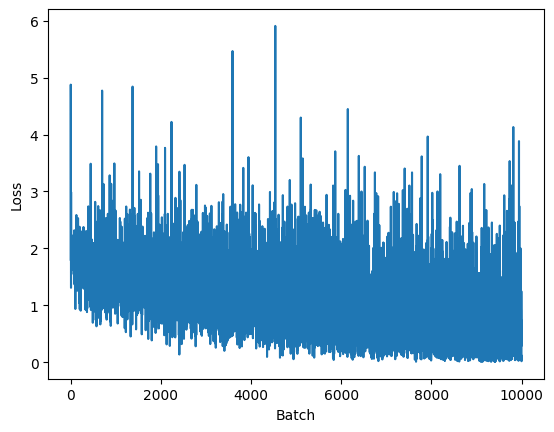

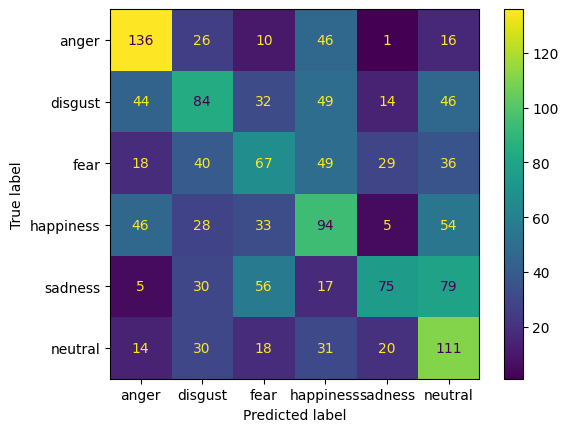

In [19]:
# evaluate(model, X_test, y_test, all_losses, emotions_ravdess)
# evaluate(model, X_test, y_test, all_losses, emotions_emodb)
evaluate(model, X_test, y_test, all_losses, emotions_cremad)


## Prediction Example

In [20]:
predict_and_display(model, X_test, y_test)

Truth:  tensor([1], device='cuda:0')
Prediction:  tensor([1], device='cuda:0')


## Cleanup

In [21]:
del model
gc.collect()
torch.cuda.empty_cache()

## Previous Results

#### Confusion Matrix, RAVDESS, sample no. 1
![Confusion Matrix, RAVDESS, sample no. 1](./assets/confusion_matrix_ravdess_1.png "Confusion Matrix, RAVDESS, sample no. 1")
#### Confusion Matrix, RAVDESS, sample no. 2
![Confusion Matrix, RAVDESS, sample no. 2](./assets/confusion_matrix_ravdess_2.png "Confusion Matrix, RAVDESS, sample no. 2")
#### Confusion Matrix, RAVDESS, sample no. 3
![Confusion Matrix, RAVDESS, sample no. 3](./assets/confusion_matrix_ravdess_3.png "Confusion Matrix, RAVDESS, sample no. 3")

## Observations
* Second derivative of MFCC is pointless(it is included in the paper), its presence decreases accuracy by ~2% (presumably because it has high correlation with first derivative) 
* Without attention, accuracy is slightly higher(~60%) but calm and angry have lower individual acc compared to the approach with attention
* With attention included, "calm" has the highest accuracy, "angry" 2nd best (exactly what we need)
* Best results for cross entropy loss were obtained with with 2000 epochs, 0.5 dropout, 4 batch size, 0.001 lr
* Network obtains ~50% acc on average, just 1-2% lower than the paper on RAVDESS
* Paper uses IEMOCAP, I have yet to train on that